In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xrft
import cartopy.crs as ccrs
from cmocean import cm

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(32)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.1.20:33137 Dashboard: http://10.148.1.20:8787/status,Cluster Workers: 34 Cores: 136 Memory: 1700.00 GB


---


# 1. Data files
#### important faces: 1, 2, 4, 5, 7, 8, 10, 11
#### other faces (polar regions): 0, 3, 6, 9, 12

In [7]:
### Here we need to load both SSU and SSV to generate the complex format of horizontal velocoty for rotary spectral calculations, u+iv

v_u = 'SSU'
v_v = 'SSV'

## data files (SSU,SSV) ##
data_dir = '/home1/scratch/xyu/mit_zarr/UV/LLC1080/'

## dir where spectra will be stored
E_dir = '/home1/scratch/xyu/mit_spec/zavg_UV/LLC1080/linear_window/'

print(data_dir)
print(E_dir)

/home1/scratch/xyu/mit_zarr/UV/LLC1080/
/home1/scratch/xyu/mit_spec/zavg_UV/LLC1080/linear_window/


## Grid

### LLC1080

In [6]:
# grid file
mgrid = xr.open_dataset('/home1/scratch/xyu/grid/mit_grid_t_1080.nc')
mgrid = mgrid.drop(['XG','YG','i_g','j_g','dxG','dyG','dxC','dyC','rAw','rAs','rAz'])
print(mgrid)

<xarray.Dataset>
Dimensions:  (face: 13, i: 1080, j: 1080)
Coordinates:
  * i        (i) int64 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 ...
  * j        (j) int64 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 ...
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (face, i, j) float32 ...
    YC       (face, i, j) float32 ...
    CS       (face, i, j) float32 ...
    SN       (face, i, j) float32 ...
    rA       (face, i, j) float32 ...
    Depth    (face, i, j) float32 ...
Data variables:
    *empty*
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(llc_method='smallchunks...


_________
# 2. FFT

## Method 2: An update on xrft

### The latest xrft supports 'time_to_segments', i.e. takes chunks along the dimension of FFT, and divides into segments (length of chunks) automatically, but it might be tricky to do overlapping.

In [11]:
face_all = [1, 2, 4, 5, 7, 8, 10, 11]
face_all = [0, 3, 6, 9, 12]
face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [ ]:
## Here we do DFT on u+iv ##
time_chunk = 1440
ij_chunk = 108

for face in face_all:
    
    # Grid #
    grid = mgrid.isel(face=face)
    
    # Read SSU #
    ds_SSU = xr.open_zarr(data_dir+'SSU_f%02d.zarr'%(face)).rename({'i_g': 'i'})
    chunks={'time': time_chunk, 'i': ij_chunk, 'j': ij_chunk} # time chunck: (2 months)
    ds_SSU = ds_SSU.chunk(chunks) 
    # Read SSV #
    ds_SSV = xr.open_zarr(data_dir+'SSV_f%02d.zarr'%(face)).rename({'j_g': 'j'})
    chunks={'time': time_chunk, 'i': ij_chunk, 'j': ij_chunk} # time chunck: (2 months)
    ds_SSV = ds_SSV.chunk(chunks) 
    # Merge into one xarray dataset #
    ds = xr.merge([ds_SSU, ds_SSV, grid])    
    #print(ds)
    #print('\n data size: %.1f GB' %(ds.nbytes / 1e9))
    
    # u+iv
    uv_complex = (ds_SSU['SSU'] + 1j*ds_SSV['SSV'])
    # fft
    #uv_fft_complex = xrft.dft(uv_complex.fillna(0.), dim=['time'], shift=False, detrend=False, window=True, chunks_to_segments=True)    
    uv_fft_complex = xrft.dft(uv_complex.fillna(0.), dim=['time'], shift=False, detrend='linear', window=True, chunks_to_segments=True)    
    E_uv_segments = (uv_fft_complex*uv_fft_complex.conj()).where(uv_fft_complex!=0., drop=False)/time_chunk*3600        
    E_uv = E_uv_segments.mean(dim=['time_segment']) 
    E_uv = np.real(E_uv).rename('E_uv')
    E_uv = xr.merge([E_uv, grid])
    file_E = E_dir+'E_uv_f%02d_1080.zarr'%face
    %time E_uv.to_zarr(file_E, mode='w')  
    print('face %d done'%face )

### 2.1 global ocean

In [11]:
def fmap(v1, v2, b1, b2):
        ''' This function provides the index of (v1,v2) coupled value position
        in the 2D histogram array
        '''
        #
        i1 = np.maximum(np.rint((v1-b1['min'])/b1['d'])+1,0)
        i1 = np.minimum(i1,b1['imax'])
        #
        i2 = np.maximum(np.rint((v2-b2['min'])/b2['d'])+1,0)
        i2 = np.minimum(i2,b2['imax'])
        return i1+i2*(b1['imax']+1)

idum = 0

for face in face_all:

    ds = xr.open_zarr(E_dir+'E_uv_f%02d_1080.zarr'%(face))
    chunks={'i': 108, 'j':108, 'freq_time':360}
    ds = ds.chunk(chunks)     
    #
    if idum == 0:
        f = ds['freq_time']
        fv = f.values
        # lat
        vb1 = {'min': -60.,'max': 60., 'd': 1.}
        # frequency
        vb2 = {'min': fv.min(), 'max': fv.max(), 'd': fv[1]-fv[0]}
        #
        vb1['imax'] = np.int(np.rint((vb1['max']-vb1['min'])/vb1['d']))+1
        vb2['imax'] = np.int(np.rint((vb2['max']-vb2['min'])/vb2['d']))+1
        #
        lat_edges = np.arange(vb1['min'], vb1['max']+vb1['d']*.1, vb1['d'])
        lat_center = (lat_edges[:-1]+lat_edges[1:])*.5
        f_edges = np.arange(vb2['min'], vb2['max']+vb2['d']*.1, vb2['d'])
        f_center = (f_edges[:-1]+f_edges[1:])*.5
        idum +=1 

    # broadcast coordinates
    lat = ds['YC']    
    lat2 = (lat + 0.*ds.E_uv).fillna(-100.)
    lat2.transpose('freq_time', 'i', 'j')  ####

    f2 = lat2.T*0. + f
    
    dA = ds.rA + 0.*f2
    dA.transpose('freq_time', 'i', 'j') ####

    EdA = ds.E_uv.fillna(0.)*dA

    # apply get_index to v1 and v2 arrays
    i = dask.array.map_blocks(fmap, lat2.T.data, f2.data, vb1, vb2,  dtype='float')
    #print(i)
    
    # compute histogram of linear indices
    h, lbins = dask.array.histogram(i, bins=np.arange(-.5,(vb1['imax']+1)*(vb2['imax']+1)+0.5,1.), \
                                    weights=EdA.data)
    hnorm, lbins = dask.array.histogram(i, bins=np.arange(-.5,(vb1['imax']+1)*(vb2['imax']+1)+0.5,1.), \
                                    weights=dA.T.data)

    # normalize and reshape
    H = h.compute()
    Hnorm = hnorm.compute()
    H = H/Hnorm
    H = H.reshape((vb1['imax']+1,vb2['imax']+1), order='F')
    Hnorm = Hnorm.reshape((vb1['imax']+1,vb2['imax']+1), order='F')

    # put H back into an xarray
    ds_zavg = xr.Dataset({'E': (['lat', 'freq_time'],  H[1:-1,1:-1]), \
                          'A': (['lat'],  Hnorm[1:-1,1])}, \
                         coords={'lat': lat_center, 'freq_time': f_center})
    ds_zavg = ds_zavg.sortby('freq_time')

    ds_zavg.to_zarr(E_dir+'E_rotary_zavg_f%02d_1080.zarr'%face, mode='w')
    print('face %d done'%face )

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


face 1 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


face 2 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


face 4 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


face 5 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


face 7 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


face 8 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


face 10 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


face 11 done


### 2.2 open ocean (deeper than 500 m)

In [ ]:
def fmap(v1, v2, b1, b2):
        ''' This function provides the index of (v1,v2) coupled value position
        in the 2D histogram array
        '''
        #
        i1 = np.maximum(np.rint((v1-b1['min'])/b1['d'])+1,0)
        i1 = np.minimum(i1,b1['imax'])
        #
        i2 = np.maximum(np.rint((v2-b2['min'])/b2['d'])+1,0)
        i2 = np.minimum(i2,b2['imax'])
        return i1+i2*(b1['imax']+1)

idum = 0

for face in face_all:

    ds = xr.open_zarr(E_dir+'E_uv_f%02d_1080.zarr'%(face))
    chunks={'i': 108, 'j':108, 'freq_time':360}
    ds = ds.chunk(chunks)     
    #
    if idum == 0:
        f = ds['freq_time']
        fv = f.values
        # lat
        vb1 = {'min': -60.,'max': 60., 'd': 1.}
        # frequency
        vb2 = {'min': fv.min(), 'max': fv.max(), 'd': fv[1]-fv[0]}
        #
        vb1['imax'] = np.int(np.rint((vb1['max']-vb1['min'])/vb1['d']))+1
        vb2['imax'] = np.int(np.rint((vb2['max']-vb2['min'])/vb2['d']))+1
        #
        lat_edges = np.arange(vb1['min'], vb1['max']+vb1['d']*.1, vb1['d'])
        lat_center = (lat_edges[:-1]+lat_edges[1:])*.5
        f_edges = np.arange(vb2['min'], vb2['max']+vb2['d']*.1, vb2['d'])
        f_center = (f_edges[:-1]+f_edges[1:])*.5
        idum +=1 

    # broadcast coordinates
    lat = ds['YC']    
    lat2 = (lat + 0.*ds.E_uv.where(ds.Depth>500)).fillna(-100.)
    lat2.transpose('freq_time', 'i', 'j')  ####

    f2 = lat2.T*0. + f
    
    dA = ds.rA + 0.*f2
    dA.transpose('freq_time', 'i', 'j') ####

    EdA = ds.E_uv.where(ds.Depth>500).fillna(0.)*dA

    # apply get_index to v1 and v2 arrays
    i = dask.array.map_blocks(fmap, lat2.T.data, f2.data, vb1, vb2,  dtype='float')
    #print(i)
    
    # compute histogram of linear indices
    h, lbins = dask.array.histogram(i, bins=np.arange(-.5,(vb1['imax']+1)*(vb2['imax']+1)+0.5,1.), \
                                    weights=EdA.data)
    hnorm, lbins = dask.array.histogram(i, bins=np.arange(-.5,(vb1['imax']+1)*(vb2['imax']+1)+0.5,1.), \
                                    weights=dA.T.data)

    # normalize and reshape
    H = h.compute()
    Hnorm = hnorm.compute()
    H = H/Hnorm
    H = H.reshape((vb1['imax']+1,vb2['imax']+1), order='F')
    Hnorm = Hnorm.reshape((vb1['imax']+1,vb2['imax']+1), order='F')

    # put H back into an xarray
    ds_zavg = xr.Dataset({'E': (['lat', 'freq_time'],  H[1:-1,1:-1]), \
                          'A': (['lat'],  Hnorm[1:-1,1])}, \
                         coords={'lat': lat_center, 'freq_time': f_center})
    ds_zavg = ds_zavg.sortby('freq_time')

    ds_zavg.to_zarr(E_dir+'E_rotary_zavg_openocean_f%02d_1080.zarr'%face, mode='w')
    print('face %d done'%face )

# 3. Figures

In [11]:
face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [12]:
D = [xr.open_zarr(E_dir+'E_rotary_zavg_openocean_f%02d_1080.zarr'%(face)) for face in face_all] # open-ocean
#D = [xr.open_zarr(E_dir+'E_rotary_zavg_f%02d_1080.zarr'%(face)) for face in face_all] # global-ocean
ds = xr.concat(D, dim='face')
print(ds)

<xarray.Dataset>
Dimensions:    (face: 13, freq_time: 1439, lat: 120)
Coordinates:
  * freq_time  (freq_time) float64 -0.0001388 -0.0001386 -0.0001384 ...
  * lat        (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 ...
Dimensions without coordinates: face
Data variables:
    A          (face, lat) float64 dask.array<shape=(13, 120), chunksize=(1, 120)>
    E          (face, lat, freq_time) float64 dask.array<shape=(13, 120, 1439), chunksize=(1, 60, 720)>


In [13]:
E = (ds.E*ds.A).sum(dim='face') / ds.A.sum(dim='face')
E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
print(E)

<xarray.DataArray (lat: 120, freq_time: 1439)>
dask.array<shape=(120, 1439), dtype=float64, chunksize=(60, 720)>
Coordinates:
  * freq_time  (freq_time) float64 -0.0001388 -0.0001386 -0.0001384 ...
  * lat        (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 ...
    freq_cpd   (freq_time) float64 -11.99 -11.98 -11.96 -11.94 -11.93 -11.91 ...


In [29]:
E = np.real(E).rename('E')
E.to_netcdf('/home1/datawork/xyu/Drifters/E.nc', mode='w')

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


### 3.1 lat-freq

### Note: (i) full colorscale [-1, 4] (ii) Shane's colorscale [0.5, 4] (iii) full frequency range [-12 12] cpd

### global ocean

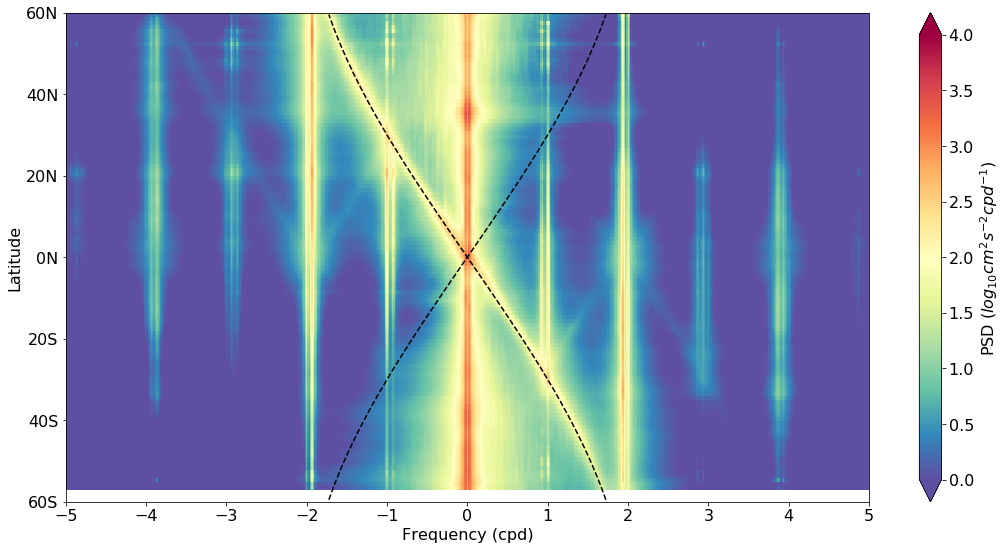

In [10]:
plt.figure(figsize=(18,9))
ax = plt.subplot(1,1,1)

E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
cax = np.log10(E/8.64).plot.pcolormesh(ax=ax, vmin=0, vmax=4., x='freq_cpd', y='lat', cmap = 'Spectral_r', add_colorbar = False)

# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=16)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=16)
            
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylabel('Latitude',fontsize=16)
ax.set_xlabel('Frequency (cpd)',fontsize=16)
ax.tick_params(labelsize=16)

# add coriolis frequency
f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.lat))
ax.plot(f*86400./2./np.pi,f.lat,'k--')
ax.plot(-f*86400./2./np.pi,f.lat,'k--')

### open ocean

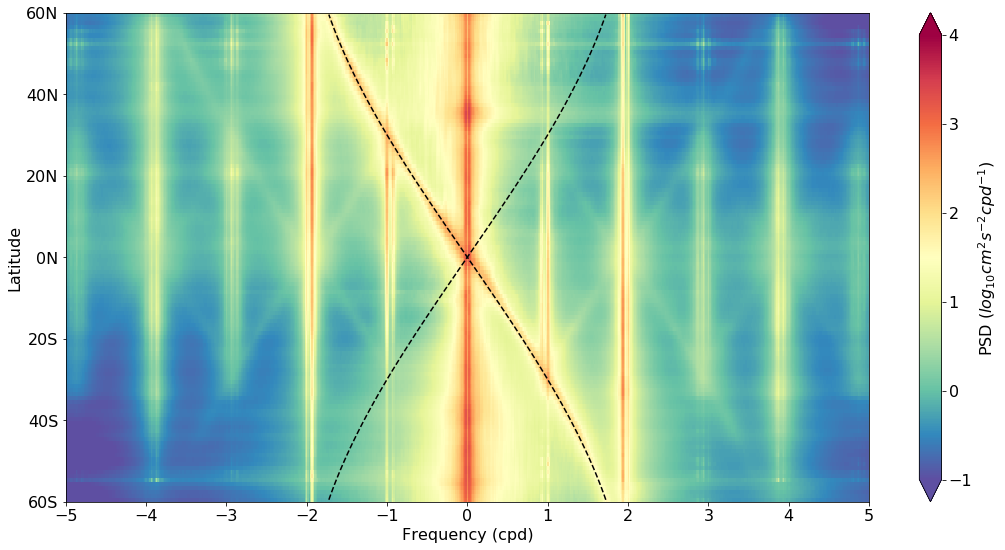

In [14]:
plt.figure(figsize=(18,9))
ax = plt.subplot(1,1,1)

E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
cax = np.log10(E/8.64).plot.pcolormesh(ax=ax, vmin=-1, vmax=4., x='freq_cpd', y='lat', cmap = 'Spectral_r', add_colorbar = False)

# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=16)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=16)
            
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylabel('Latitude',fontsize=16)
ax.set_xlabel('Frequency (cpd)',fontsize=16)
ax.tick_params(labelsize=16)

# add coriolis frequency
f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.lat))
ax.plot(f*86400./2./np.pi,f.lat,'k--')
ax.plot(-f*86400./2./np.pi,f.lat,'k--')

### 3.2 Band-frequency integral

In [15]:
E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
print(E)

<xarray.DataArray (lat: 120, freq_time: 1439)>
dask.array<shape=(120, 1439), dtype=float64, chunksize=(60, 720)>
Coordinates:
  * freq_time  (freq_time) float64 -0.0001388 -0.0001386 -0.0001384 ...
  * lat        (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 ...
    freq_cpd   (freq_time) float64 -11.99 -11.98 -11.96 -11.94 -11.93 -11.91 ...


In [16]:
df=E.freq_time[1]-E.freq_time[0]
print(df)

<xarray.DataArray 'freq_time' ()>
array(1.929012e-07)


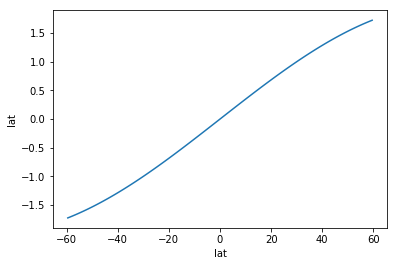

In [17]:
# Inertial frequency
f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.lat))
f_cpd = f*86400/2./np.pi
f_cpd.plot()

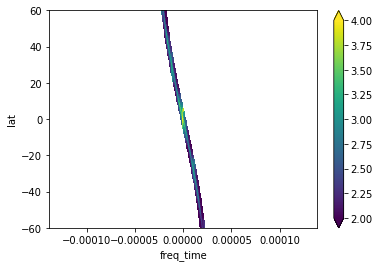

In [18]:
np.log10(E.where(abs(E.freq_cpd+f_cpd)<.2, other=0.)).plot(vmin=2, vmax=4)

## Total energy vs Band-frequency integral

### open ocean

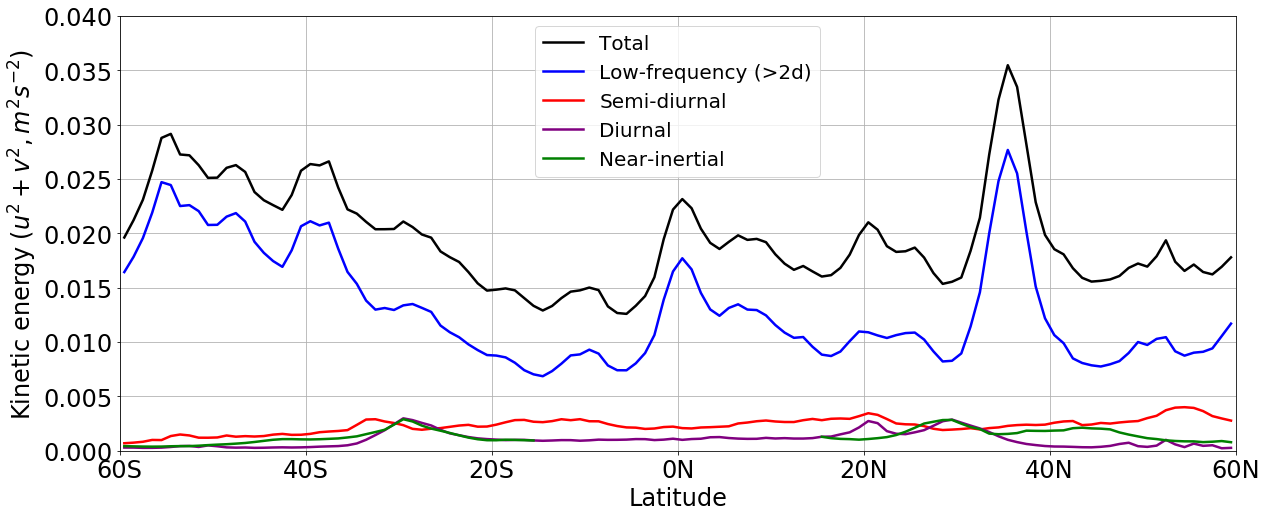

In [19]:
fig, ax = plt.subplots(figsize=(20,8))

labels = ['Total', 'Low-frequency (>2d)','Semi-diurnal', 'Diurnal', 'Near-inertial']


(E*df).sum(dim='freq_time').plot(color='black', label=labels[0], linewidth=2.5) # total energy
(E.where((abs(E.freq_cpd)>0) & (abs(E.freq_cpd)<0.5) , other=0.)*df).sum(dim='freq_time').plot(color='blue', label=labels[1], linewidth=2.5)   # energy at low frequencies (> 5 days) 
(E.where((abs(E.freq_cpd)>1.9) & (abs(E.freq_cpd)<2.1) , other=0.)*df).sum(dim='freq_time').plot(color='red', label=labels[2], linewidth=2.5) # energy around semi-diurnal frequencies
(E.where((abs(E.freq_cpd)>0.9) & (abs(E.freq_cpd)<1.1) , other=0.)*df).sum(dim='freq_time').plot(color='purple', label=labels[3], linewidth=2.5) # energy around diurnal frequencies
(E.where(abs(E.freq_cpd+f_cpd)<.1, other=0.)*df).sum(dim='freq_time').where(abs(E.lat)>15).plot(color='green', label=labels[4], linewidth=2.5) # energy around f
ax.legend(prop={'size': 20}); ax.grid()

# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.04])

# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)

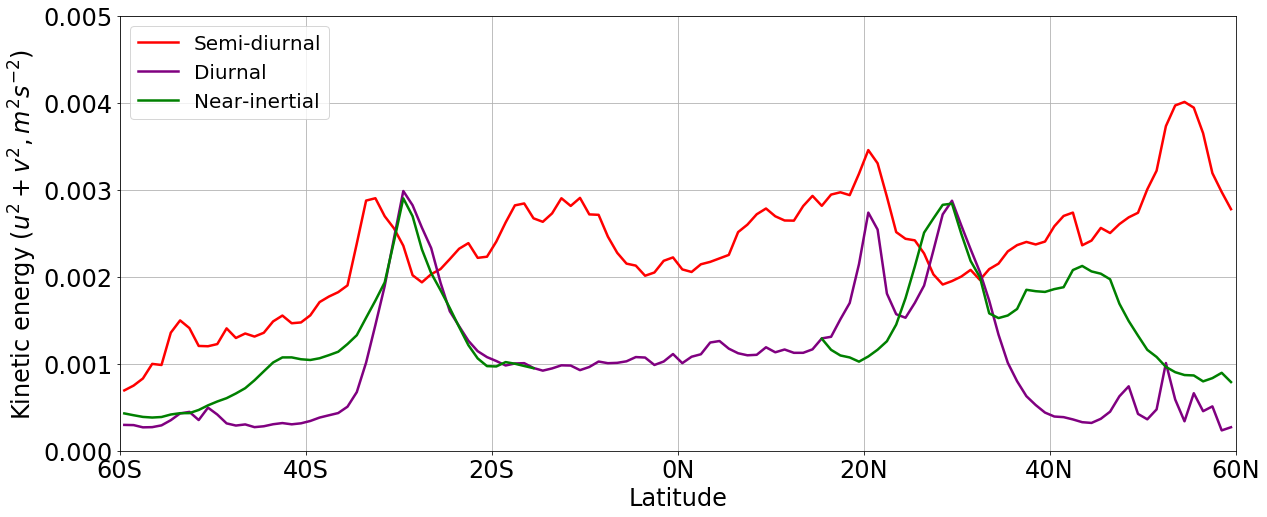

In [20]:
fig, ax = plt.subplots(figsize=(20,8))

labels = ['Total', 'Low-frequency (>2d)','Semi-diurnal', 'Diurnal', 'Near-inertial']

(E.where((abs(E.freq_cpd)>1.9) & (abs(E.freq_cpd)<2.1) , other=0.)*df).sum(dim='freq_time').plot(color='red', label=labels[2], linewidth=2.5) # energy around semi-diurnal frequencies
(E.where((abs(E.freq_cpd)>0.9) & (abs(E.freq_cpd)<1.1) , other=0.)*df).sum(dim='freq_time').plot(color='purple', label=labels[3], linewidth=2.5) # energy around diurnal frequencies
(E.where(abs(E.freq_cpd+f_cpd)<.1, other=0.)*df).sum(dim='freq_time').where(abs(E.lat)>15).plot(color='green', label=labels[4], linewidth=2.5) # energy around f
ax.legend(prop={'size': 20}); ax.grid()

# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.005])

# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)

### global ocean

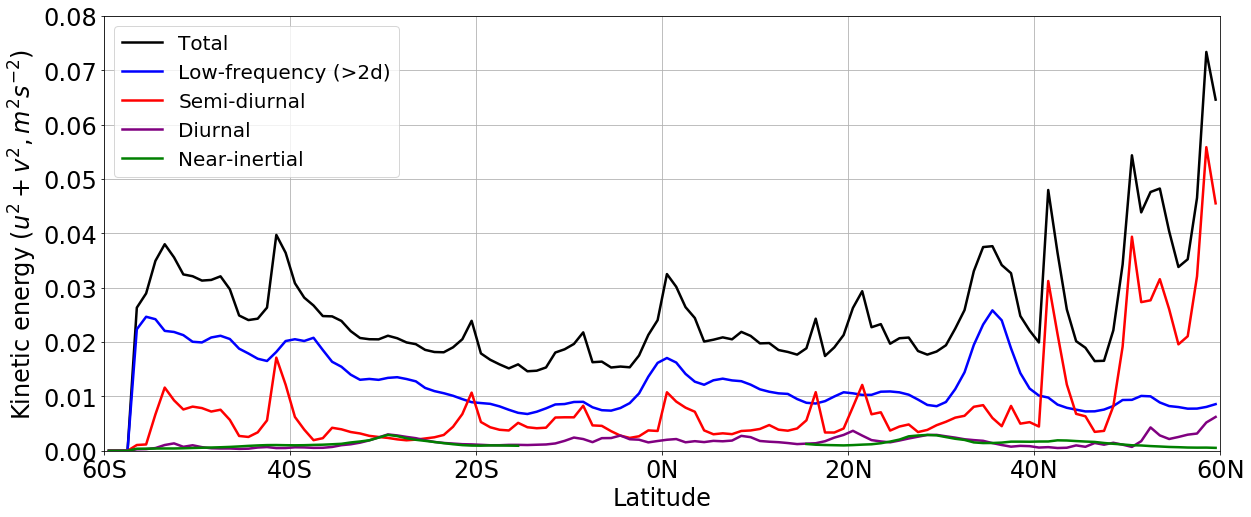

In [19]:
fig, ax = plt.subplots(figsize=(20,8))

labels = ['Total', 'Low-frequency (>2d)','Semi-diurnal', 'Diurnal', 'Near-inertial']


(E*df).sum(dim='freq_time').plot(color='black', label=labels[0], linewidth=2.5) # total energy
(E.where((abs(E.freq_cpd)>0) & (abs(E.freq_cpd)<0.5) , other=0.)*df).sum(dim='freq_time').plot(color='blue', label=labels[1], linewidth=2.5)   # energy at low frequencies (> 5 days) 
(E.where((abs(E.freq_cpd)>1.9) & (abs(E.freq_cpd)<2.1) , other=0.)*df).sum(dim='freq_time').plot(color='red', label=labels[2], linewidth=2.5) # energy around semi-diurnal frequencies
(E.where((abs(E.freq_cpd)>0.9) & (abs(E.freq_cpd)<1.1) , other=0.)*df).sum(dim='freq_time').plot(color='purple', label=labels[3], linewidth=2.5) # energy around diurnal frequencies
(E.where(abs(E.freq_cpd+f_cpd)<.1, other=0.)*df).sum(dim='freq_time').where(abs(E.lat)>15).plot(color='green', label=labels[4], linewidth=2.5) # energy around f
ax.legend(prop={'size': 20}); ax.grid()

# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.08])

# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)

### 3.3 global-averaged

In [8]:
D = [xr.open_zarr(E_dir+'E_uv_f%02d_1080.zarr'%(face)) for face in face_all]
ds = xr.concat(D, dim='face')

In [9]:
E_uv_north = ((ds.E_uv).where((ds.YC>0.) & (ds.Depth>500.))).mean(dim=('i','j','face'))   
E_uv_north = np.real(E_uv_north).rename('E_uv_north')
file_E = E_dir+'E_uv_north_allmean_openocean.zarr'  
%time E_uv_north.to_dataset().to_zarr(file_E, mode='w')

CPU times: user 25 s, sys: 1.43 s, total: 26.5 s
Wall time: 39.8 s


In [10]:
E_uv_south = ((ds.E_uv).where((ds.YC<0.) & (ds.Depth>500.))).mean(dim=('i','j','face'))   
E_uv_south = np.real(E_uv_south).rename('E_uv_south')
file_E = E_dir+'E_uv_south_allmean_openocean.zarr'  
%time E_uv_south.to_dataset().to_zarr(file_E, mode='w')

CPU times: user 26.6 s, sys: 1.28 s, total: 27.9 s
Wall time: 42.6 s


In [11]:
ds = xr.open_zarr(E_dir+'E_uv_south_allmean_openocean.zarr')
print(ds)

<xarray.Dataset>
Dimensions:            (freq_time: 1440)
Coordinates:
  * freq_time          (freq_time) float64 0.0 1.929e-07 3.858e-07 5.787e-07 ...
    freq_time_spacing  float64 ...
Data variables:
    E_uv_south         (freq_time) float64 dask.array<shape=(1440,), chunksize=(1440,)>


In [12]:
E_south = ds.E_uv_south
E_south = E_south.assign_coords(freq_time=ds.E_uv_south.freq_time * 86400.) 
print(E_south)

<xarray.DataArray 'E_uv_south' (freq_time: 1440)>
dask.array<shape=(1440,), dtype=float64, chunksize=(1440,)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 ...


In [13]:
E0_south = E_south/8.64

In [14]:
ds0 = xr.open_zarr(E_dir+'E_uv_north_allmean_openocean.zarr')
print(ds0)

<xarray.Dataset>
Dimensions:            (freq_time: 1440)
Coordinates:
  * freq_time          (freq_time) float64 0.0 1.929e-07 3.858e-07 5.787e-07 ...
    freq_time_spacing  float64 ...
Data variables:
    E_uv_north         (freq_time) float64 dask.array<shape=(1440,), chunksize=(1440,)>


In [15]:
E_north = ds0.E_uv_north
E_north = E_north.assign_coords(freq_time=ds0.E_uv_north.freq_time * 86400.) 
print(E_north)

<xarray.DataArray 'E_uv_north' (freq_time: 1440)>
dask.array<shape=(1440,), dtype=float64, chunksize=(1440,)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 ...


In [16]:
E0_north = E_north/8.64

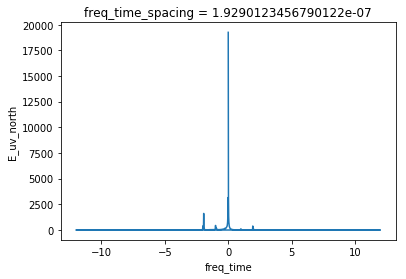

In [17]:
E0_north.plot()

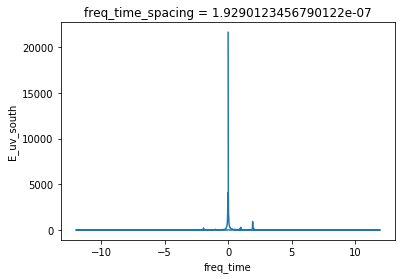

In [18]:
E0_south.plot()

In [19]:
E0_south_anti = E0_south.where(E0_south.freq_time>0)
print(E0_south_anti)

E0_north_anti = E0_north.where(E0_north.freq_time<0)
E0_north_anti = E0_north_anti.assign_coords(freq_time=E_north.freq_time * -1.) 
print(E0_north_anti)

<xarray.DataArray (freq_time: 1440)>
dask.array<shape=(1440,), dtype=float64, chunksize=(1440,)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 1.929e-07
<xarray.DataArray (freq_time: 1440)>
dask.array<shape=(1440,), dtype=float64, chunksize=(1440,)>
Coordinates:
  * freq_time          (freq_time) float64 -0.0 -0.01667 -0.03333 -0.05 ...
    freq_time_spacing  float64 ...


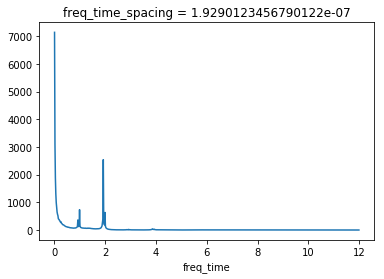

In [20]:
E0_anti = E0_north_anti + E0_south_anti
E0_anti.plot()

In [21]:
E0_south_cycl = E0_south.where(E0_south.freq_time<0)
print(E0_south_cycl)

E0_north_cycl = E0_north.where(E0_north.freq_time>0)
E0_north_cycl = E0_north_cycl.assign_coords(freq_time=E_north.freq_time * -1.) 
print(E0_north_cycl)

<xarray.DataArray (freq_time: 1440)>
dask.array<shape=(1440,), dtype=float64, chunksize=(1440,)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 1.929e-07
<xarray.DataArray (freq_time: 1440)>
dask.array<shape=(1440,), dtype=float64, chunksize=(1440,)>
Coordinates:
  * freq_time          (freq_time) float64 -0.0 -0.01667 -0.03333 -0.05 ...
    freq_time_spacing  float64 ...


In [22]:
E0_cycl = E0_north_cycl + E0_south_cycl
E0_cycl = E0_cycl.assign_coords(freq_time=E0_cycl.freq_time * -1.) 

print(E0_cycl)

<xarray.DataArray (freq_time: 1439)>
dask.array<shape=(1439,), dtype=float64, chunksize=(1439,)>
Coordinates:
  * freq_time          (freq_time) float64 -0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 1.929e-07


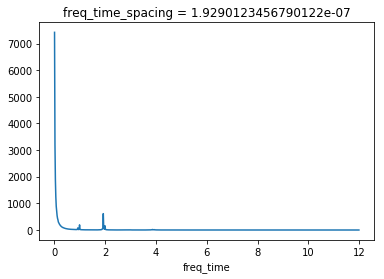

In [23]:
E0_cycl.plot()

In [24]:
E_cycl_all = E0_cycl
E_anti_all = E0_anti

In [25]:
E_cycl_all = np.real(E_cycl_all).rename('E_cycl_all')
file_E = E_dir+'E_cycl_all_openocean.zarr'  
%time E_cycl_all.to_dataset().to_zarr(file_E, mode='w')

CPU times: user 32 ms, sys: 12 ms, total: 44 ms
Wall time: 85.5 ms


In [26]:
E_anti_all = np.real(E_anti_all).rename('E_anti_all')
file_E = E_dir+'E_anti_all_openocean.zarr'  
%time E_anti_all.to_dataset().to_zarr(file_E, mode='w')

CPU times: user 48 ms, sys: 8 ms, total: 56 ms
Wall time: 92.7 ms


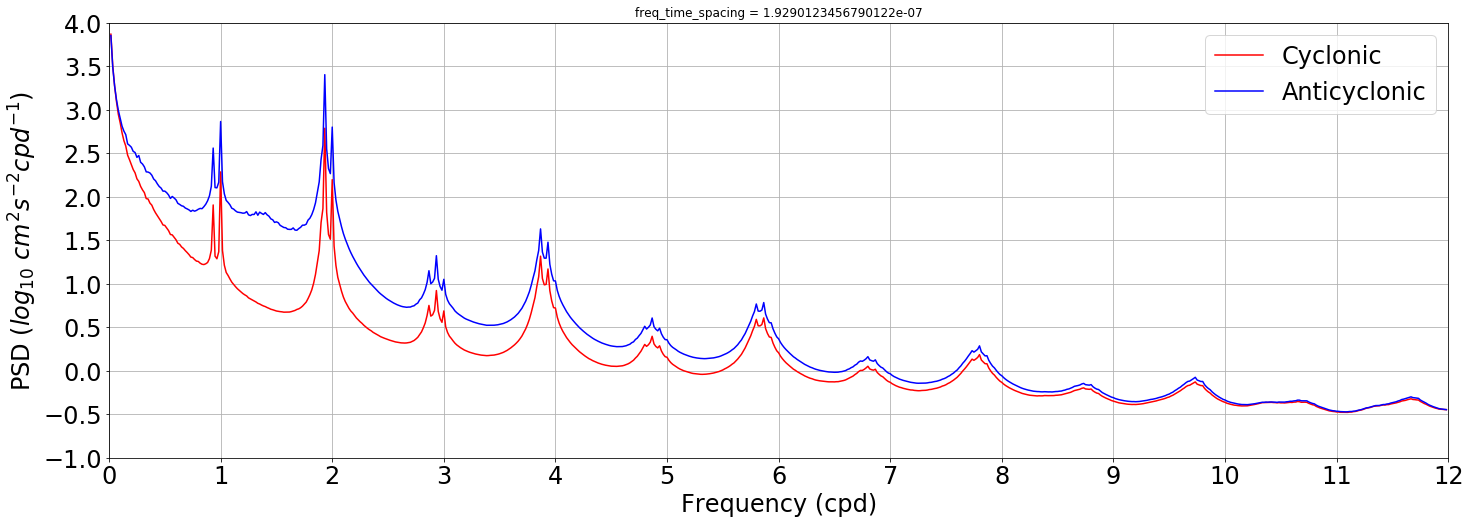

In [27]:

fig, ax = plt.subplots(figsize=(24,8))

labels = ['Cyclonic', 'Anticyclonic']

(np.log10(E_cycl_all).where(E_cycl_all.freq_time>0)).plot(ax=ax,color='red', label=labels[0])
(np.log10(E_anti_all).where(E_anti_all.freq_time>0)).plot(ax=ax,color='blue', label=labels[1])

ax.legend(); ax.grid()
#ax.set_yscale('log')
ax.set_ylim([-1.,4.])
ax.set_yticks([-1, -0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5, 4.])

ax.set_xlim([0.,12.])
#ax.set_ylim([1e-1,1e4])


ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
#ax.set_title('All the world oceans',fontsize=24)


Text(0.5,1,'All the world oceans')

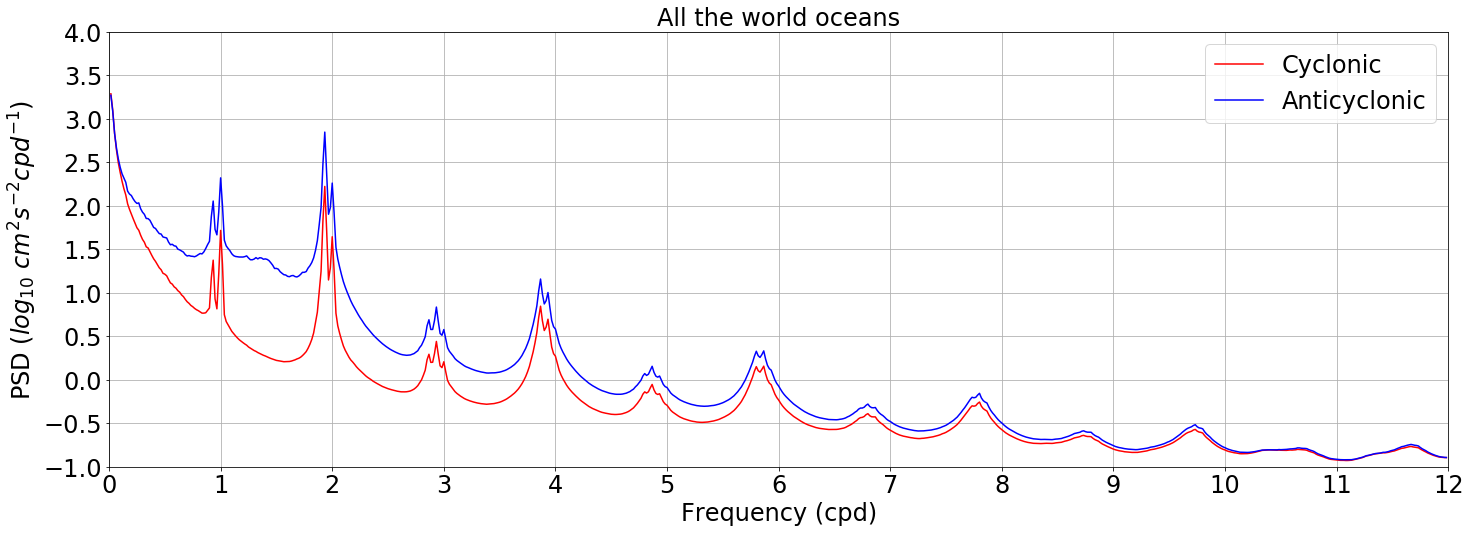

In [38]:

fig, ax = plt.subplots(figsize=(24,8))

labels = ['Cyclonic', 'Anticyclonic']

(np.log10(E_cycl_all).where(E_cycl_all.freq_time>0)).plot(ax=ax,color='red', label=labels[0])
(np.log10(E_anti_all).where(E_anti_all.freq_time>0)).plot(ax=ax,color='blue', label=labels[1])

ax.legend(); ax.grid()
#ax.set_yscale('log')
ax.set_ylim([-1.,4.])
ax.set_yticks([-1, -0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5, 4.])

ax.set_xlim([0.,12.])
#ax.set_ylim([1e-1,1e4])


ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
#ax.set_title('All the world oceans',fontsize=24)


# 3. compare different conditions

In [10]:
face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
E_dir = '/home1/scratch/xyu/mit_spec/zavg_UV/LLC1080/'

In [11]:
D = [xr.open_zarr(E_dir+'raw/E_rotary_zavg_openocean_f%02d_1080.zarr'%(face)) for face in face_all] # open-ocean
ds = xr.concat(D, dim='face')
E = (ds.E*ds.A).sum(dim='face') / ds.A.sum(dim='face')
E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
E_raw = np.real(E).rename('E_raw')
E_raw

<xarray.DataArray 'E_raw' (lat: 120, freq_time: 1439)>
dask.array<shape=(120, 1439), dtype=float64, chunksize=(60, 720)>
Coordinates:
  * freq_time  (freq_time) float64 -0.0001388 -0.0001386 -0.0001384 ...
  * lat        (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 ...
    freq_cpd   (freq_time) float64 -11.99 -11.98 -11.96 -11.94 -11.93 -11.91 ...

In [12]:
D = [xr.open_zarr(E_dir+'window/E_rotary_zavg_openocean_f%02d_1080.zarr'%(face)) for face in face_all] # open-ocean
ds = xr.concat(D, dim='face')
E = (ds.E*ds.A).sum(dim='face') / ds.A.sum(dim='face')
E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
E_window = np.real(E).rename('E_window')
E_window

<xarray.DataArray 'E_window' (lat: 120, freq_time: 1439)>
dask.array<shape=(120, 1439), dtype=float64, chunksize=(60, 720)>
Coordinates:
  * freq_time  (freq_time) float64 -0.0001388 -0.0001386 -0.0001384 ...
  * lat        (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 ...
    freq_cpd   (freq_time) float64 -11.99 -11.98 -11.96 -11.94 -11.93 -11.91 ...

In [14]:
D = [xr.open_zarr(E_dir+'constant/E_rotary_zavg_openocean_f%02d_1080.zarr'%(face)) for face in face_all] # open-ocean
ds = xr.concat(D, dim='face')
E = (ds.E*ds.A).sum(dim='face') / ds.A.sum(dim='face')
E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
E_constant = np.real(E).rename('E_constant')
E_constant

<xarray.DataArray 'E_constant' (lat: 120, freq_time: 1439)>
dask.array<shape=(120, 1439), dtype=float64, chunksize=(60, 720)>
Coordinates:
  * freq_time  (freq_time) float64 -0.0001388 -0.0001386 -0.0001384 ...
  * lat        (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 ...
    freq_cpd   (freq_time) float64 -11.99 -11.98 -11.96 -11.94 -11.93 -11.91 ...

In [15]:
D = [xr.open_zarr(E_dir+'constant_window/E_rotary_zavg_openocean_f%02d_1080.zarr'%(face)) for face in face_all] # open-ocean
ds = xr.concat(D, dim='face')
E = (ds.E*ds.A).sum(dim='face') / ds.A.sum(dim='face')
E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
E_constant_window = np.real(E).rename('E_constant_window')
E_constant_window

<xarray.DataArray 'E_constant_window' (lat: 120, freq_time: 1439)>
dask.array<shape=(120, 1439), dtype=float64, chunksize=(60, 720)>
Coordinates:
  * freq_time  (freq_time) float64 -0.0001388 -0.0001386 -0.0001384 ...
  * lat        (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 ...
    freq_cpd   (freq_time) float64 -11.99 -11.98 -11.96 -11.94 -11.93 -11.91 ...

In [16]:
df=E_raw.freq_time[1]-E_raw.freq_time[0]
print(df)

<xarray.DataArray 'freq_time' ()>
array(1.929012e-07)


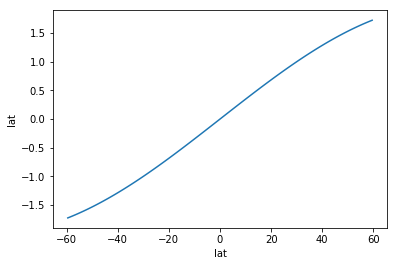

In [17]:
# Inertial frequency
f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.lat))
f_cpd = f*86400/2./np.pi
f_cpd.plot()

### open ocean

Text(0.5,1,'LLC4320 (total)')

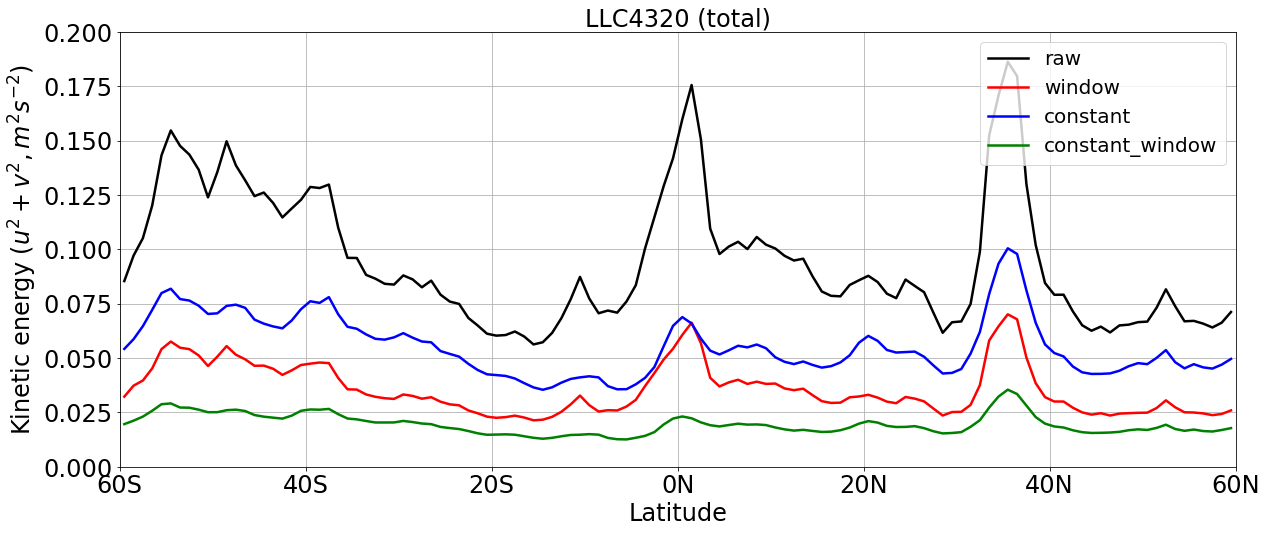

In [19]:
fig, ax = plt.subplots(figsize=(20,8))

labels = ['raw', 'window','constant','constant_window']

(E_raw*df).sum(dim='freq_time').plot(color='black', label=labels[0], linewidth=2.5) # total energy
(E_window*df).sum(dim='freq_time').plot(color='red', label=labels[1], linewidth=2.5) # total energy
(E_constant*df).sum(dim='freq_time').plot(color='blue', label=labels[2], linewidth=2.5) # total energy
(E_constant_window*df).sum(dim='freq_time').plot(color='green', label=labels[3], linewidth=2.5) # total energy

ax.legend(prop={'size': 20}); ax.grid()

# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.2])

# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('LLC4320 (total)',fontsize=24)

Text(0.5,1,'LLC4320 (low-frequency)')

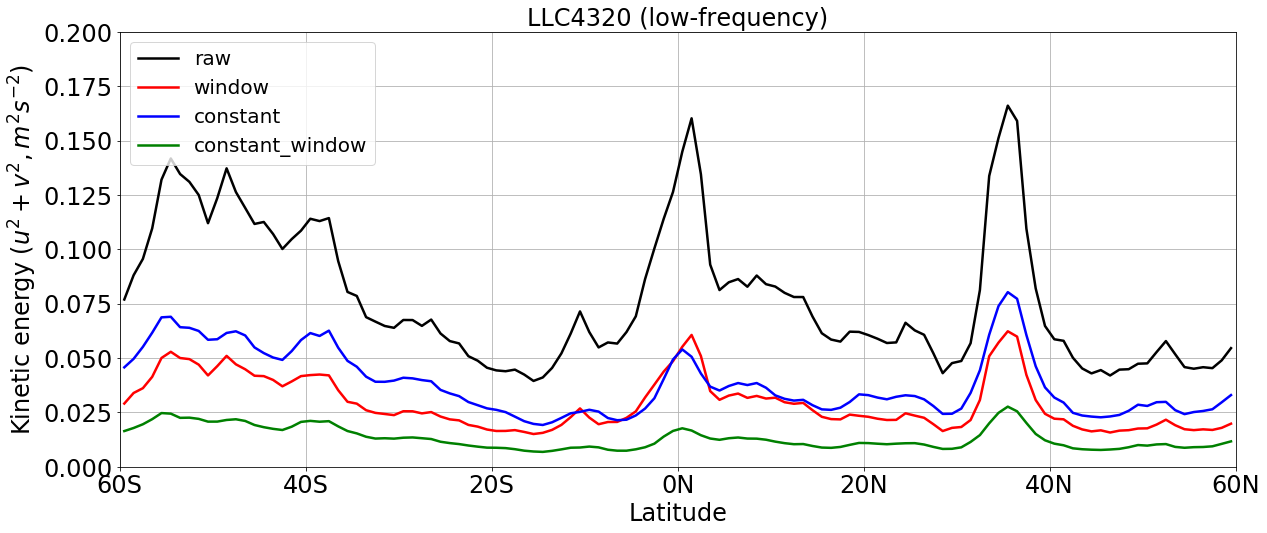

In [20]:
fig, ax = plt.subplots(figsize=(20,8))

labels = ['raw', 'window','constant','constant_window']

(E_raw.where((abs(E_raw.freq_cpd)>0) & (abs(E_raw.freq_cpd)<0.5) , other=0.)*df).sum(dim='freq_time').plot(color='black', label=labels[0], linewidth=2.5) # total energy
(E_window.where((abs(E_window.freq_cpd)>0) & (abs(E_window.freq_cpd)<0.5) , other=0.)*df).sum(dim='freq_time').plot(color='red', label=labels[1], linewidth=2.5) # total energy
(E_constant.where((abs(E_constant.freq_cpd)>0) & (abs(E_constant.freq_cpd)<0.5) , other=0.)*df).sum(dim='freq_time').plot(color='blue', label=labels[2], linewidth=2.5) # total energy
(E_constant_window.where((abs(E_constant_window.freq_cpd)>0) & (abs(E_constant_window.freq_cpd)<0.5) , other=0.)*df).sum(dim='freq_time').plot(color='green', label=labels[3], linewidth=2.5) # total energy

ax.legend(prop={'size': 20}); ax.grid()

# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.2])

# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('LLC4320 (low-frequency)',fontsize=24)

Text(0.5,1,'LLC4320 (semi-diurnal)')

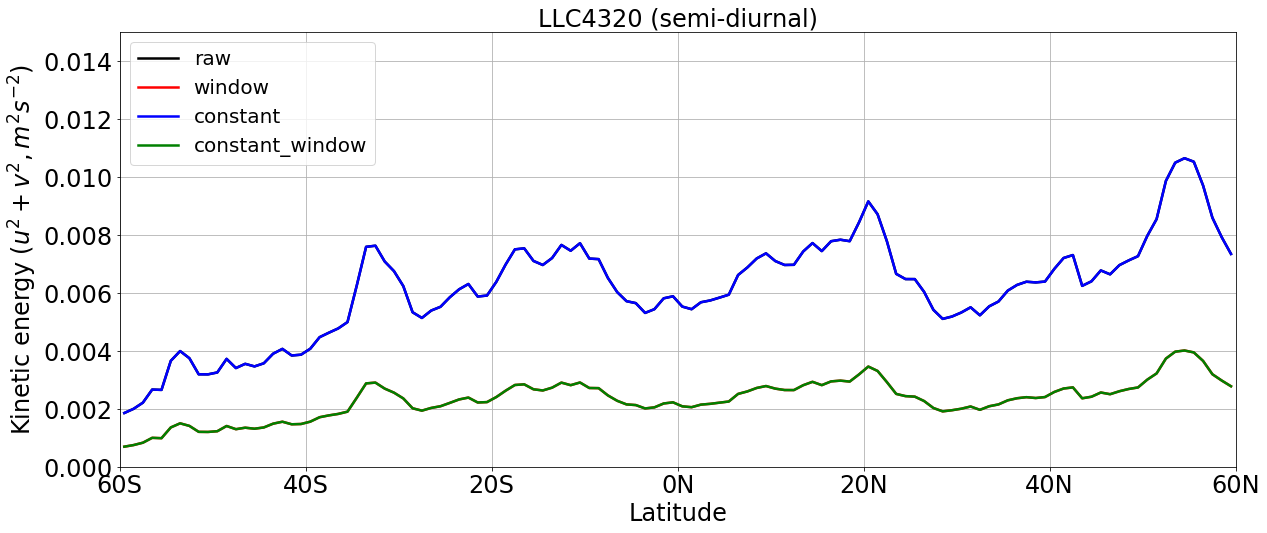

In [22]:
fig, ax = plt.subplots(figsize=(20,8))

labels = ['raw', 'window','constant','constant_window']

(E_raw.where((abs(E_raw.freq_cpd)>1.9) & (abs(E_raw.freq_cpd)<2.1) , other=0.)*df).sum(dim='freq_time').plot(color='black', label=labels[0], linewidth=2.5) # total energy
(E_window.where((abs(E_window.freq_cpd)>1.9) & (abs(E_window.freq_cpd)<2.1) , other=0.)*df).sum(dim='freq_time').plot(color='red', label=labels[1], linewidth=2.5) # total energy
(E_constant.where((abs(E_constant.freq_cpd)>1.9) & (abs(E_constant.freq_cpd)<2.1) , other=0.)*df).sum(dim='freq_time').plot(color='blue', label=labels[2], linewidth=2.5) # total energy
(E_constant_window.where((abs(E_constant_window.freq_cpd)>1.9) & (abs(E_constant_window.freq_cpd)<2.1) , other=0.)*df).sum(dim='freq_time').plot(color='green', label=labels[3], linewidth=2.5) # total energy

ax.legend(prop={'size': 20}); ax.grid()

# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.015])

# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('LLC4320 (semi-diurnal)',fontsize=24)

Text(0.5,1,'LLC4320 (diurnal)')

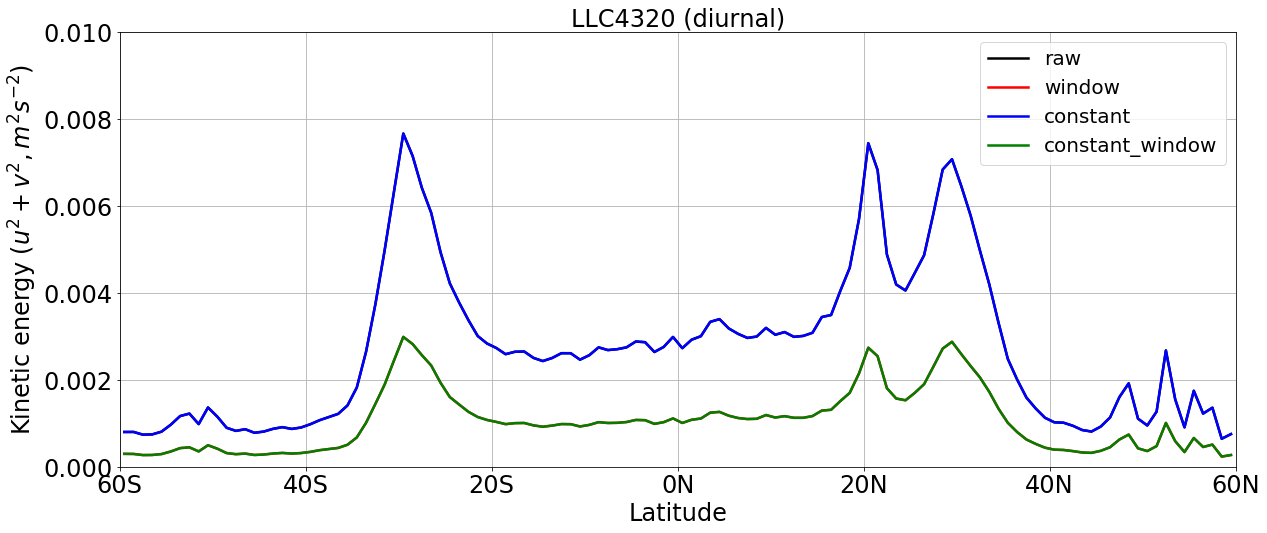

In [23]:
fig, ax = plt.subplots(figsize=(20,8))

labels = ['raw', 'window','constant','constant_window']

(E_raw.where((abs(E_raw.freq_cpd)>0.9) & (abs(E_raw.freq_cpd)<1.1) , other=0.)*df).sum(dim='freq_time').plot(color='black', label=labels[0], linewidth=2.5) # total energy
(E_window.where((abs(E_window.freq_cpd)>0.9) & (abs(E_window.freq_cpd)<1.1) , other=0.)*df).sum(dim='freq_time').plot(color='red', label=labels[1], linewidth=2.5) # total energy
(E_constant.where((abs(E_constant.freq_cpd)>0.9) & (abs(E_constant.freq_cpd)<1.1) , other=0.)*df).sum(dim='freq_time').plot(color='blue', label=labels[2], linewidth=2.5) # total energy
(E_constant_window.where((abs(E_constant_window.freq_cpd)>0.9) & (abs(E_constant_window.freq_cpd)<1.1) , other=0.)*df).sum(dim='freq_time').plot(color='green', label=labels[3], linewidth=2.5) # total energy

ax.legend(prop={'size': 20}); ax.grid()

# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.01])

# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('LLC4320 (diurnal)',fontsize=24)

Text(0.5,1,'LLC4320 (high-frequency)')

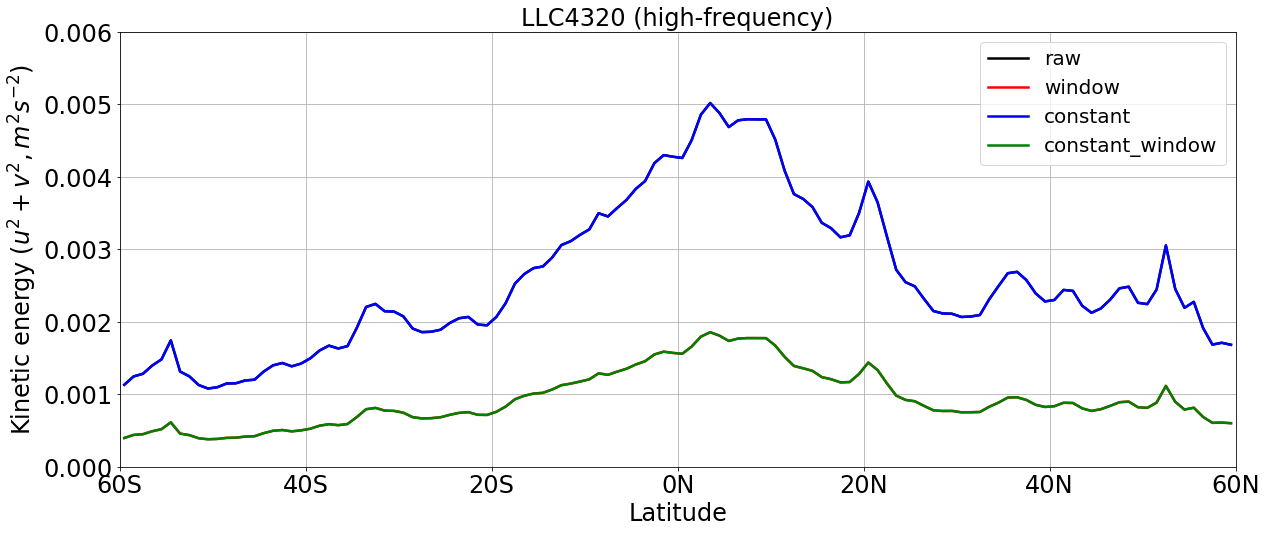

In [24]:
fig, ax = plt.subplots(figsize=(20,8))

labels = ['raw', 'window','constant','constant_window']

(E_raw.where((abs(E_raw.freq_cpd)>2.1), other=0.)*df).sum(dim='freq_time').plot(color='black', label=labels[0], linewidth=2.5) # total energy
(E_window.where((abs(E_window.freq_cpd)>2.1), other=0.)*df).sum(dim='freq_time').plot(color='red', label=labels[1], linewidth=2.5) # total energy
(E_constant.where((abs(E_constant.freq_cpd)>2.1), other=0.)*df).sum(dim='freq_time').plot(color='blue', label=labels[2], linewidth=2.5) # total energy
(E_constant_window.where((abs(E_constant_window.freq_cpd)>2.1), other=0.)*df).sum(dim='freq_time').plot(color='green', label=labels[3], linewidth=2.5) # total energy

ax.legend(prop={'size': 20}); ax.grid()

# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.006])

# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('LLC4320 (high-frequency)',fontsize=24)

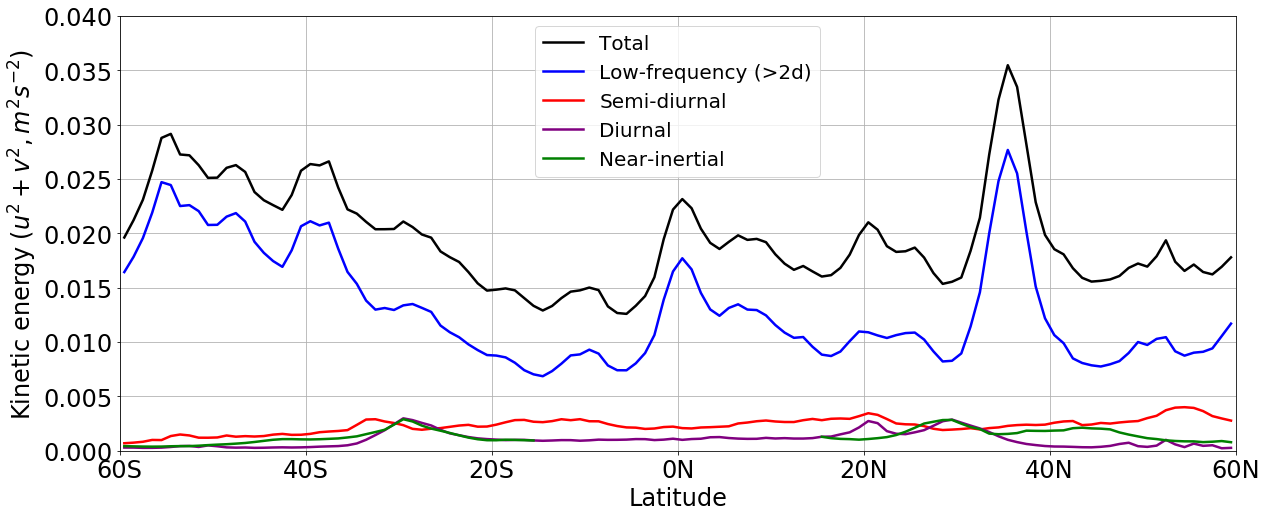

In [19]:
fig, ax = plt.subplots(figsize=(20,8))

labels = ['Total', 'Low-frequency (>2d)','Semi-diurnal', 'Diurnal', 'Near-inertial']


(E*df).sum(dim='freq_time').plot(color='black', label=labels[0], linewidth=2.5) # total energy
(E.where((abs(E.freq_cpd)>0) & (abs(E.freq_cpd)<0.5) , other=0.)*df).sum(dim='freq_time').plot(color='blue', label=labels[1], linewidth=2.5)   # energy at low frequencies (> 5 days) 
(E.where((abs(E.freq_cpd)>1.9) & (abs(E.freq_cpd)<2.1) , other=0.)*df).sum(dim='freq_time').plot(color='red', label=labels[2], linewidth=2.5) # energy around semi-diurnal frequencies
(E.where((abs(E.freq_cpd)>0.9) & (abs(E.freq_cpd)<1.1) , other=0.)*df).sum(dim='freq_time').plot(color='purple', label=labels[3], linewidth=2.5) # energy around diurnal frequencies
(E.where(abs(E.freq_cpd+f_cpd)<.1, other=0.)*df).sum(dim='freq_time').where(abs(E.lat)>15).plot(color='green', label=labels[4], linewidth=2.5) # energy around f
ax.legend(prop={'size': 20}); ax.grid()

# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.04])

# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)

In [18]:
cluster.scheduler.close()

<Future finished result=None>